In [1]:
'''
!git clone https://github.com/rajanlab/CURBD.git
import os 
os.chdir('/content/CURBD/')
'''

"\n!git clone https://github.com/rajanlab/CURBD.git\nimport os \nos.chdir('/content/CURBD/')\n"

In [4]:
import numpy as np
import numpy.random as npr
import pylab
import curbd
import math
import matplotlib.pyplot as plt
#%matplotlib
import seaborn as sns


import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import torch.optim as optim
import pickle 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


c:\Users\Andrew\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
'''sim = curbd.threeRegionSim(number_units=100,
                           ga=1.8,
                           gb=1.5,
                           gc=1.5,
                           tau=0.1,
                           fracInterReg=0.05,
                           ampInterReg=0.02,
                           fracExternal=0.5,
                           ampInB=1,
                           ampInC=-1,
                           dtData=0.01,
                           T=10,
                           leadTime=2,
                           bumpStd=0.2,
                           )'''

'''with open("simulation.pkl", "wb") as f:
    pickle.dump(sim, f)'''

'sim = curbd.threeRegionSim(number_units=100,\n                           ga=1.8,\n                           gb=1.5,\n                           gc=1.5,\n                           tau=0.1,\n                           fracInterReg=0.05,\n                           ampInterReg=0.02,\n                           fracExternal=0.5,\n                           ampInB=1,\n                           ampInC=-1,\n                           dtData=0.01,\n                           T=10,\n                           leadTime=2,\n                           bumpStd=0.2,\n                           )'

In [45]:
sim = torch.load("REAL_SIM.pt")

In [46]:
#three regions with each region having 100 units and 1201 time series data
activity = np.concatenate((sim['Ra'], sim['Rb'], sim['Rc']), 0) #300 x 1201
activity = activity[:,:300]

Na = sim['params']['Na']
Nb = sim['params']['Nb']
Nc = sim['params']['Nc']

regions = []
regions.append(['Region A', np.arange(0, Na)])
regions.append(['Region B', np.arange(Na, Na + Nb)])
regions.append(['Region C', np.arange(Na + Nb, Na + Nb + Nc)])
regions = np.array(regions, dtype=object)

# Initializing the parameters 

In [47]:
dtData=sim['params']['dtData'] # time step of training data
# dtData=None
dtFactor=5 # number of interpolation steps for RNN 
regions=regions # number of regions and names of the regions
# tauRNN=2*sim['params']['tau']/2 # decay constant of RNN 
tauRNN=50 # decay constant of RNN 

g=1.5 # instability constant 
tauWN=0.1 #decay constant on filtered white noise inputs
ampInWN=0.01 #input amplitude of filtered white noise 
resetPoints=None
plotStatus=True
regions=None


In [48]:
if dtData is None: #0.01
    print('dtData not specified. Defaulting to 1.');
    dtData = 1;
if resetPoints is None:
    resetPoints = [0, ]
if regions is None:
    regions = {}

In [49]:
number_units = activity.shape[0] #300 -- the total number of units 
number_learn = activity.shape[0] #300
dtRNN = dtData / float(dtFactor) # 0.01/5=0.002

In [50]:
learnList = npr.permutation(number_units) #randomize the units
iTarget = learnList[:number_learn]
iNonTarget = learnList[number_learn:] # []

tData = dtData*np.arange(activity.shape[1]) #   [0, 0.01, 0.02 ....,12.01] #1201 input time steps 
tRNN = np.arange(0, tData[-1] + dtRNN, dtRNN) # [0, 0.002, 0.004 ...., 12.01] #6000 rnn time steps

# External Input to RNN

In [51]:
ampWN = math.sqrt(tauWN/dtRNN) # (0.1/0.002)
iWN = ampWN * npr.randn(number_units, len(tRNN)) #gaussian noise ? #300x6001
inputWN = np.ones((number_units, len(tRNN))) #300x6001
# print("inputWN : ",inputWN)
for tt in range(1, len(tRNN)):
    inputWN[:, tt] = iWN[:, tt] + (inputWN[:, tt - 1] - iWN[:, tt])*np.exp(- (dtRNN / tauWN)) # solve the above differential equation 
inputWN = ampInWN * inputWN # external input h(t)


# Set up target training data

In [52]:
Adata = activity.copy()
Adata = Adata/Adata.max()
Adata = np.minimum(Adata, 0.999) # elementwise minimum 
Adata = np.maximum(Adata, -0.999) # elementwise max
print (Adata.shape)

(300, 300)


# Model Definition

In [100]:
import sys 

class CTRNN(nn.Module):
    """Continuous-time RNN."""
    def __init__(self,
                 g,
                 tauRNN,
                 dtRNN,
                 input_units,
                 output_units,
                 dt=None,
                 interregion_sparsity=0.1, #Lower = more sparse, 1 to disable
                 **kwargs):
      
        super(CTRNN,self).__init__()

        self.tauRNN = tauRNN
        self.dtRNN=dtRNN
        self.g=g
        self.input_units=input_units
        self.output_units=output_units
        
        
#        print(self.J)
        mask = torch.ones(300,300)
        mask[:100, 100:300] = torch.rand_like(mask[:100, 100:300]) <= interregion_sparsity
        mask[100:200, 0:100] = torch.rand_like(mask[100:200, 0:100]) <= interregion_sparsity
        mask[100:200, 200:] = torch.rand_like(mask[100:200, 200:]) <= interregion_sparsity
        mask[200:,0:200] = torch.rand_like(mask[200:,0:200]) <= interregion_sparsity
        self.mask = mask
        self.J = nn.Parameter((self.g * torch.Tensor(npr.randn(input_units, output_units) / math.sqrt(output_units)))  * self.mask )

        #print(torch.numel(mask[0:100, 100:]))
      
    def forward(self, hidden, noise=None):
        if(noise is not None):
           noise = torch.zeros_like(noise)
        
        """Propogate input through the network."""
        
        # When calculating fixed points: We want to find _hidden_ vectors such that -hidden + JR equals the 0 vector.
        activation = torch.tanh(torch.Tensor(hidden))
        JR = torch.matmul(self.J, activation).reshape((self.input_units,1))
        

        new_hidden = hidden + self.dtRNN*(-hidden + JR)/self.tauRNN
        return activation, new_hidden



In [112]:
rnn_model = CTRNN(g=g,
                  tauRNN=tauRNN,
                  dtRNN=dtRNN,
                  input_units=number_units,
                  output_units=number_units,
                  interregion_sparsity=0.1
                  )

# Training

In [113]:
optimizer = optim.Adam(rnn_model.parameters(), lr=3e-1)
criterion = nn.MSELoss()
loss_list = []
# RNN = np.zeros((number_units, len(tRNN)))
saved_LEs = []

for epoch in range(151):
    if(epoch % 30 == 0):
       saved_LEs.append(calculate_lyapunov_exponents(rnn_model, iterations=100))
       
    tLearn = 0 
    iLearn = 0 
    loss = 0

    hidden = torch.tanh(torch.Tensor(Adata[:, 0, np.newaxis])).to(device)
    # RNN[:, 0, np.newaxis] = hidden.detach().cpu().numpy()
    # output = hidden
    for i in range(1,len(tRNN)):
        tLearn += dtRNN
        
        # RNN[:, i, np.newaxis] = output.detach().cpu().numpy()

        output, hidden = rnn_model(hidden,
                                  torch.Tensor(inputWN[:, i, np.newaxis]).to(device))
        

        if tLearn >= dtData:
          tLearn=0
          running_loss = criterion(output,
                                   torch.Tensor(Adata[:, iLearn ,np.newaxis]).to(device))
          iLearn = iLearn + 1 
          loss+=running_loss
    optimizer.zero_grad()   # zero the gradient buffers
    if (epoch)%1 ==0 :
      print (f"Epoch is {epoch}, loss is {loss}")
    loss.backward()
    
    rnn_model.J.grad *= rnn_model.mask


    optimizer.step()    # Does the update
    loss_list.append(loss)

Epoch is 0, loss is 148.44366455078125
Epoch is 1, loss is 96.95308685302734
Epoch is 2, loss is 74.02584075927734
Epoch is 3, loss is 64.5141830444336
Epoch is 4, loss is 59.44781494140625
Epoch is 5, loss is 55.67951583862305
Epoch is 6, loss is 52.73139190673828
Epoch is 7, loss is 50.61386489868164
Epoch is 8, loss is 48.773990631103516
Epoch is 9, loss is 46.979305267333984
Epoch is 10, loss is 45.28992462158203
Epoch is 11, loss is 43.79042053222656
Epoch is 12, loss is 42.40071487426758
Epoch is 13, loss is 41.130619049072266
Epoch is 14, loss is 40.03103256225586
Epoch is 15, loss is 39.34748840332031
Epoch is 16, loss is 41.382781982421875
Epoch is 17, loss is 37.52671813964844
Epoch is 18, loss is 48.62327194213867
Epoch is 19, loss is 42.245933532714844
Epoch is 20, loss is 49.982444763183594
Epoch is 21, loss is 50.20461654663086
Epoch is 22, loss is 47.25807189941406
Epoch is 23, loss is 43.936622619628906
Epoch is 24, loss is 41.34172821044922
Epoch is 25, loss is 39.7848

In [115]:
torch.save(rnn_model.state_dict(), "interregion_sparse.pt")

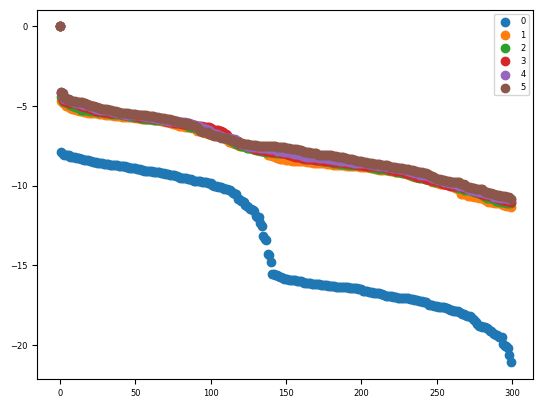

In [114]:
len(saved_LEs)

for i, LEs in enumerate(saved_LEs):
    plt.scatter(np.arange(300), torch.sort(LEs, dim=0, descending=True).values.detach().numpy(), label=f'{i}')

plt.legend()
plt.show()

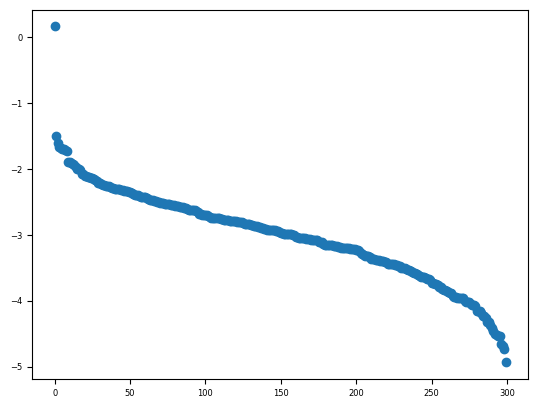

In [40]:
plt.scatter(np.arange(300), torch.sort(total_exponents, dim=0, descending=True).values.detach().numpy())

In [41]:
def calculate_lyapunov_exponents(model, iterations=2000):
    hidden = torch.zeros(300,1)
    hidden = torch.Tensor(Adata[:, 0, np.newaxis])

    Q = torch.reshape(torch.eye(300),  (1,300,300)).to('cpu')

    model.eval()
    total_exponents = torch.zeros(300,1)
    for i in range(iterations):
        output, new_hidden = model(hidden)
        hidden = new_hidden
        jac = jacobian(model, hidden)[1].squeeze()
        
        Q = torch.matmul(jac, Q)
        
        upper_triangular_matrix = torch.linalg.qr(Q).R
   
        total_exponents += torch.log(abs(torch.diagonal(upper_triangular_matrix)))

    total_exponents /= iterations
    return total_exponents

In [38]:
hidden = torch.zeros(300,1)
hidden = torch.Tensor(Adata[:, 0, np.newaxis])

Q = torch.reshape(torch.eye(300),  (1,300,300)).to('cpu')

rnn_model.eval()
total_exponents = torch.zeros(300,1)
iterations = 2000
for i in range(iterations):
    output, new_hidden = rnn_model(hidden)
    hidden = new_hidden
    jac = jacobian(rnn_model, hidden)[1].squeeze()
    
    Q = torch.matmul(jac, Q)
    
    upper_triangular_matrix = torch.linalg.qr(Q).R
   # print(upper_triangular_matrix.shape)
 
 #   s = torch.diag_embed(torch.sign(torch.diagonal(upper_triangular_matrix)))#extract sign of each leading r value
 #   print(s.shape)
 #   Q = torch.matmul(Q.squeeze(), s.squeeze())
 #   r = torch.diagonal(torch.matmul(s.squeeze(), upper_triangular_matrix)) #return positive r values and corresponding vectors
 #   print(Q.shape)
    total_exponents += torch.log(abs(torch.diagonal(upper_triangular_matrix)))

total_exponents /= iterations
print(total_exponents)

tensor([[ 0.1586],
        [-2.2505],
        [-2.7982],
        [-2.6249],
        [-3.6356],
        [-3.3192],
        [-2.1042],
        [-2.1742],
        [-2.1442],
        [-3.4155],
        [-2.1450],
        [-2.8344],
        [-2.4814],
        [-2.8670],
        [-1.9773],
        [-2.9107],
        [-2.3256],
        [-2.3362],
        [-1.5081],
        [-2.2226],
        [-2.5367],
        [-3.3191],
        [-2.4184],
        [-4.3286],
        [-2.0175],
        [-2.5159],
        [-2.1262],
        [-2.4253],
        [-2.5377],
        [-2.3012],
        [-2.1183],
        [-1.6950],
        [-3.2762],
        [-3.2176],
        [-2.5539],
        [-3.9532],
        [-3.0459],
        [-2.2453],
        [-2.2313],
        [-3.1988],
        [-2.0076],
        [-2.9231],
        [-2.1599],
        [-2.7917],
        [-2.3584],
        [-2.3409],
        [-2.6987],
        [-2.0847],
        [-3.1131],
        [-2.8545],
        [-3.1450],
        [-3.0642],
        [-2.